In [1]:
import pandas as pd
import math
import nltk
import time
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer

## 1. Data overview

In [2]:
reviews = pd.read_csv('datasets/movie_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [3]:
reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [4]:
reviews.duplicated().sum()

0

In [5]:
reviews.isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

Constatações:
* x total de registros
* 2 valores faltantes em y e z

## 2. Pre-processing

In [6]:
# eliminating missing values
reviews.dropna(inplace=True)

## 3. EDA

##### Equilíbrio de classes

In [7]:
labels = reviews['pos'].value_counts()
labels

0    23715
1    23614
Name: pos, dtype: int64

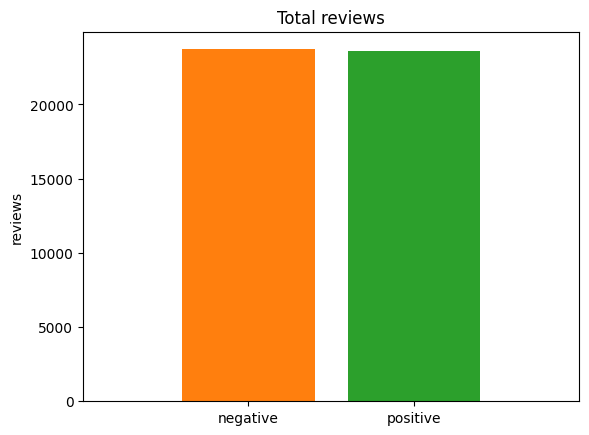

In [8]:
plt.bar([0,1], labels, color=['C1', 'C2'])
plt.xlim(-1,2)
plt.xticks([0,1], ['negative','positive'])
plt.ylabel('reviews')
plt.title('Total reviews')
plt.show()

A quantidade de reviews está bem equilibrada, tanto positivas e negativas. A seguir os dados serão preparados para a etapa de teste de modelos e seleção do melhor.

## 4. Data preparation

In [9]:
# function to prepare texts to ML training
def text_preprocess(text):
    text = text.lower() # minúsculas
    words = nltk.word_tokenize(text, language='english') # Tokenização (separação em palavras)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words] # Remove stopwords e aplica lematização
    return " ".join(words)

In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [11]:
reviews['review_preprocessed'] = reviews['review'].apply(text_preprocess)

In [12]:
train = reviews.query('ds_part == "train"').copy()
test = reviews.query('ds_part == "test"').copy()

X_train = train['review_preprocessed']
y_train = train['pos']

X_test = test['review_preprocessed']
y_test = test['pos']

In [13]:
vectorizer = CountVectorizer()

In [14]:
# transform texts into vectors
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

## 5. Modeling

In [15]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'CatBoost Classifier': CatBoostClassifier(verbose=False, random_state=42),
    'Random Forest Classifier': RandomForestClassifier(random_state=42)
}

In [16]:
params = {
    'Logistic Regression': {'C': [0.01, 0.1, 1.0]},
    'CatBoost Classifier': {'learning_rate': [0.1, 0.2], 'n_estimators': [7, 21]},
    'Random Forest Classifier': {'n_estimators': [10, 21, 100], 'max_depth': [7, 21]}
}

In [23]:
res = {'Model':[],
       'F1-Score':[],
       'duration':[],
       'best_params':[]}

for model_name, model in models.items():
    start_time = time.time()
    grid_search = GridSearchCV(model, params[model_name], scoring=make_scorer(f1_score), n_jobs=1, cv=3)
    grid_search.fit(X_train_vectorized, y_train)
    
    # print("Top Parâmetros:", grid_search.best_params_)

    end_time = time.time()
    
    res['Model'].append(model_name)
    res['F1-Score'].append(grid_search.best_score_)
    res['duration'].append(f'{(end_time - start_time):.0f}s')
    res['best_params'].append(grid_search.best_params_)

res = pd.DataFrame(res)
eval = res.drop(columns='best_params').sort_values(by='F1-Score',ascending=False)
eval

,Model,F1-Score,duration
0,Logistic Regression,0.864582,25s
2,Random Forest Classifier,0.842257,143s
1,CatBoost Classifier,0.812540,134s
